In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
import keras.backend as K
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import joblib
from joblib import load
from keras.models import model_from_json
import matplotlib.pyplot as plt

In [4]:
print("Se está cargando el dataset, aguarde un momento...")
filePath = "C:/Users/raul.blanco/Documents/4 - Personales/UBA/Repositorios/IA/Trabajo-Final/test_data_u.csv"
test_data_u = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=",")
test_data_u = test_data_u.dropna()
test_data_u = test_data_u.drop(['timedelta', 'Unnamed: 0'], axis=1)
print("Dataset test_data_u cargado correctamente.")

Se está cargando el dataset, aguarde un momento...
Dataset test_data_u cargado correctamente.


In [5]:
print("Se está cargando el dataset, aguarde un momento...")
filePath = "C:/Users/raul.blanco/Documents/4 - Personales/UBA/Repositorios/IA/Trabajo-Final/test_data_n.csv"
test_data_n = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=",")
test_data_n = test_data_n.dropna()
test_data_n = test_data_n.drop(['timedelta', 'Unnamed: 0'], axis=1)
print("Dataset test_data_n cargado correctamente.")

Se está cargando el dataset, aguarde un momento...
Dataset test_data_n cargado correctamente.


In [6]:
test_data_u.head()

,period,bx_gse,by_gse,bz_gse,theta_gse,phi_gse,bx_gsm,by_gsm,bz_gsm,theta_gsm,phi_gsm,bt,density,speed,temperature,source,class
0,train_c,1.17,-2.54,0.65,13.16,294.66,1.16,-2.33,1.21,24.92,296.50,2.87,4.71,353.47,33302.0,ac,0
1,train_c,1.13,-2.66,-0.17,-3.45,292.94,1.12,-2.63,0.43,8.54,293.04,2.89,5.12,349.25,41200.0,ac,0
2,train_c,0.63,-2.98,-0.21,-3.86,281.96,0.63,-2.95,0.47,8.88,281.98,3.05,3.55,351.36,34041.0,ac,0
3,train_c,1.76,-2.01,0.16,3.42,311.17,1.75,-1.92,0.61,13.15,312.32,2.67,4.81,353.56,25111.0,ac,0
4,train_c,1.61,-2.20,0.16,3.31,306.17,1.60,-2.11,0.65,13.76,307.25,2.73,4.42,348.54,57336.0,ac,0


In [7]:
count = (test_data_u['class'] == 1).sum()
count1 = (test_data_u['class'] == 0).sum()
print(f'En el dataset test_data_u el número de anomalias es {count} y {count1} son valores normales')

En el dataset test_data_u el número de anomalias es 15142 y 1499075 son valores normales


In [8]:
count = (test_data_n['class'] == 1).sum()
count1 = (test_data_n['class'] == 0).sum()
print(f'En el datset test_data_n el número de anomalias es {count} y {count1} son valores normales')

En el datset test_data_n el número de anomalias es 15142 y 1499075 son valores normales


Se realiza One Hot Encodging

In [9]:
test_data_u = pd.get_dummies(test_data_u, columns=['source', 'period'], prefix=['source', 'period'])
test_data_n = pd.get_dummies(test_data_n, columns=['source', 'period'], prefix=['source', 'period'])

In [10]:
X_test_u = test_data_u.drop('class', axis=1).values
y_test_u = test_data_u['class'].values
X_test_n = test_data_n.drop('class', axis=1).values
y_test_n = test_data_n['class'].values

Dataset_u

In [11]:
scaler = StandardScaler()
X_test_scaled_u = scaler.fit_transform(X_test_u)
componentes = 9
pca = PCA(n_components = componentes)
data_test_X_u = pca.fit_transform(X_test_scaled_u)

Dataset_n

In [26]:
scaler = StandardScaler()
X_test_scaled_n = scaler.fit_transform(X_test_n)
componentes = 9
pca = PCA(n_components = componentes)
data_test_X_n = pca.fit_transform(X_test_scaled_n)

### RBM

Uniforme

In [16]:
while True:
    name = input("Ingrese el nombre de los archivos a cargar sin extensión para el modelo RBM entrenado con anomalías uniformes: ")
    
    try:
        json_file = open(f'{name}.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        
        rbm_model_u = model_from_json(loaded_model_json)
        rbm_model_u.load_weights(f'{name}.h5')
        
        print(f'Modelo {name} cargado desde la unidad local')
        break
        
    except FileNotFoundError:
        print(f'El archivo {name} no fue encontrado. Por favor, ingrese un nombre válido.')

El archivo rbm-n no fue encontrado. Por favor, ingrese un nombre válido.
Modelo rbm_u cargado desde la unidad local


In [17]:
X_test_pred_RBM_u = rbm_model_u.predict(data_test_X_u)

47320/47320 [==============================] - 39s 826us/step


Threshold =  4.2


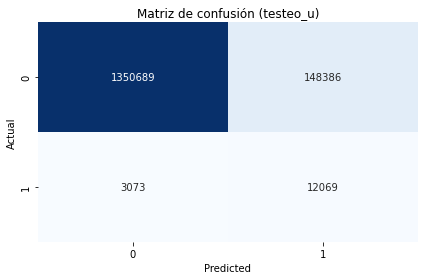

Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      0.90      0.95   1499075
           1       0.08      0.80      0.14     15142

    accuracy                           0.90   1514217
   macro avg       0.54      0.85      0.54   1514217
weighted avg       0.99      0.90      0.94   1514217



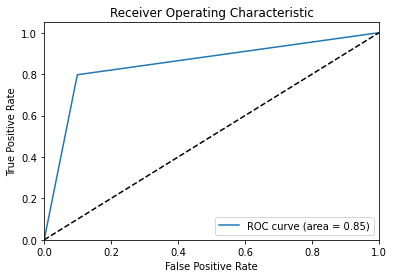

AUC: 0.8490347547412086
Threshold =  4.2


In [28]:
threshold = float(input("Ingrese el Threshold a utilizar: "))
print("Threshold = ", threshold)
#Se etiquetan las anomalías en función del umbral
y_test_pred_RBM_u = np.where(np.linalg.norm(data_test_X_u - X_test_pred_RBM_u, axis=1) > threshold, 1, 0)
#Matriz de confusión
cm_test = confusion_matrix(y_test_u, y_test_pred_RBM_u)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Matriz de confusión (testeo_u)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Calcular el reporte de métricas
classification_test = classification_report(y_test_u, y_test_pred_RBM_u)
print('Classification Report (Test):\n', classification_test)

# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test_u, y_test_pred_RBM_u)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
print('AUC:', roc_auc)
print("Threshold = ", threshold)

Normal

In [24]:
while True:
    name = input("Ingrese el nombre de los archivos a cargar sin extensión para el modelo RBM entrenado con anomalías normales: ")
    
    try:
        json_file = open(f'{name}.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        
        rbm_model_n = model_from_json(loaded_model_json)
        rbm_model_n.load_weights(f'{name}.h5')
        
        print(f'Modelo {name} cargado desde la unidad local')
        break
        
    except FileNotFoundError:
        print(f'El archivo {name} no fue encontrado. Por favor, ingrese un nombre válido.')

Modelo rbm_n cargado desde la unidad local


In [27]:
X_test_pred_RBM_n = rbm_model_n.predict(data_test_X_n)

47320/47320 [==============================] - 38s 792us/step


Threshold =  7.6


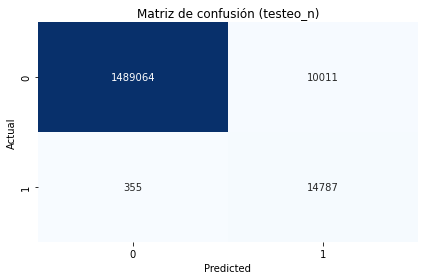

Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      0.99      1.00   1499075
           1       0.60      0.98      0.74     15142

    accuracy                           0.99   1514217
   macro avg       0.80      0.98      0.87   1514217
weighted avg       1.00      0.99      0.99   1514217



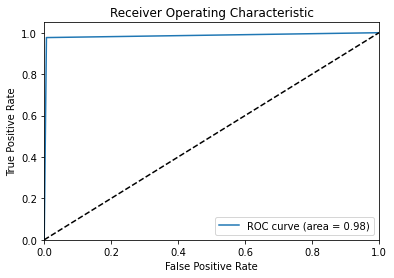

AUC: 0.9849385792704515
Threshold =  7.6


In [46]:
threshold = float(input("Ingrese el Threshold a utilizar: "))
print("Threshold = ", threshold)
#Se etiquetan las anomalías en función del umbral
y_test_pred_RBM_n = np.where(np.linalg.norm(data_test_X_n - X_test_pred_RBM_n, axis=1) > threshold, 1, 0)
#Matriz de confusión
cm_test = confusion_matrix(y_test_n, y_test_pred_RBM_n)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Matriz de confusión (testeo_n)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Calcular el reporte de métricas
classification_test = classification_report(y_test_n, y_test_pred_RBM_n)
print('Classification Report (Test):\n', classification_test)

# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test_n, y_test_pred_RBM_n)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
print('AUC:', roc_auc)
print("Threshold = ", threshold)

### LSTM Autoencoder

Uniforme

In [82]:
while True:
    name = input("Ingrese el nombre de los archivos a cargar sin extensión para el modelo LSTM Autoencoder entrenado con anomalías uniformes: ")
    
    try:
        json_file = open(f'{name}.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        
        autoencoder_u = model_from_json(loaded_model_json)
        autoencoder_u.load_weights(f'{name}.h5')
        
        print(f'Modelo {name} cargado desde la unidad local')
        break
        
    except FileNotFoundError:
        print(f'El archivo {name} no fue encontrado. Por favor, ingrese un nombre válido.')

Modelo autoencoder_u_1 cargado desde la unidad local


In [83]:
X_test_3d_u = data_test_X_u.reshape(data_test_X_u.shape[0], 1, data_test_X_u.shape[1])

In [84]:
X_test_3d_pred_u = autoencoder_u.predict(X_test_3d_u)

47320/47320 [==============================] - 83s 2ms/step


In [85]:
X_test_3d_pred_u = autoencoder_u.predict(X_test_3d_u)

47320/47320 [==============================] - 83s 2ms/step


Threshold =  7.3


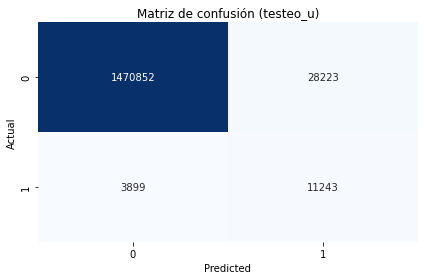

Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      0.98      0.99   1499075
           1       0.28      0.74      0.41     15142

    accuracy                           0.98   1514217
   macro avg       0.64      0.86      0.70   1514217
weighted avg       0.99      0.98      0.98   1514217



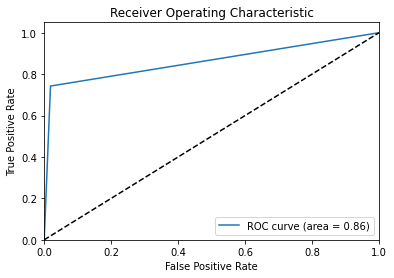

AUC: 0.8618386747070614
Threshold =  7.3


In [94]:
threshold = float(input("Ingrese el Threshold a utilizar: "))
print("Threshold = ", threshold)
#Se etiquetan las anomalías en función del umbral
y_test_pred_lstm_u = np.where(np.linalg.norm(X_test_3d_u - X_test_3d_pred_u, axis=(1, 2)) > threshold, 1, 0)
#Matriz de confusión
cm_test = confusion_matrix(y_test_u, y_test_pred_lstm_u)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Matriz de confusión (testeo_u)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
# Calcular el reporte de métricas
classification_test = classification_report(y_test_u, y_test_pred_lstm_u)
print('Classification Report (Test):\n', classification_test)
# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test_u, y_test_pred_lstm_u)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
print('AUC:', roc_auc)
print("Threshold = ", threshold)

Normal

In [87]:
while True:
    name = input("Ingrese el nombre de los archivos a cargar sin extensión para el modelo LSTM Autoencoder entrenado con anomalías normal: ")
    
    try:
        json_file = open(f'{name}.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        
        autoencoder_n = model_from_json(loaded_model_json)
        autoencoder_n.load_weights(f'{name}.h5')
        
        print(f'Modelo {name} cargado desde la unidad local')
        break
        
    except FileNotFoundError:
        print(f'El archivo {name} no fue encontrado. Por favor, ingrese un nombre válido.')

Modelo autoencoder_n_1 cargado desde la unidad local


In [88]:
X_test_3d_n = data_test_X_n.reshape(data_test_X_n.shape[0], 1, data_test_X_n.shape[1])

In [89]:
X_test_3d_pred_n = autoencoder_n.predict(X_test_3d_n)

47320/47320 [==============================] - 83s 2ms/step


Threshold =  16.0


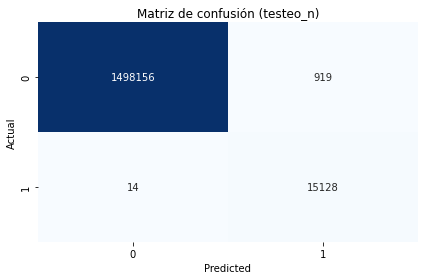

Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1499075
           1       0.94      1.00      0.97     15142

    accuracy                           1.00   1514217
   macro avg       0.97      1.00      0.98   1514217
weighted avg       1.00      1.00      1.00   1514217



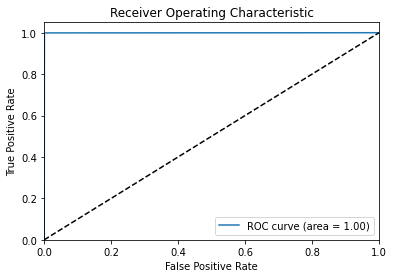

AUC: 0.9992311873262275
Threshold =  16.0


In [109]:
threshold = float(input("Ingrese el Threshold a utilizar: "))
print("Threshold = ", threshold)
#Se etiquetan las anomalías en función del umbral
y_test_pred_lstm_n = np.where(np.linalg.norm(X_test_3d_n - X_test_3d_pred_n, axis=(1, 2)) > threshold, 1, 0)
#Matriz de confusión
cm_test = confusion_matrix(y_test_n, y_test_pred_lstm_n)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Matriz de confusión (testeo_n)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()
# Calcular el reporte de métricas
classification_test = classification_report(y_test_n, y_test_pred_lstm_n)
print('Classification Report (Test):\n', classification_test)
# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test_n, y_test_pred_lstm_n)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
print('AUC:', roc_auc)
print("Threshold = ", threshold)

### Isolation Forest

Uniforme

In [72]:
while True:
    name = input("Ingrese el nombre de los archivos a cargar sin extensión para el modelo Isolation Forest entrenado con anomalías uniformes: ")
    
    try:
        model_if_u = load(f'{name}.joblib')
        print(f'Modelo {name} cargado desde la unidad local')
        break
        
    except FileNotFoundError:
        print(f'El archivo {name} no fue encontrado. Por favor, ingrese un nombre válido.')

Modelo if_u cargado desde la unidad local


In [73]:
X_test_pred_if_u = model_if_u.predict(data_test_X_u)

In [75]:
X_test_pred_if_u = np.where(X_test_pred_if_u == 1, 0, np.where(X_test_pred_if_u == -1, 1, X_test_pred_if_u))

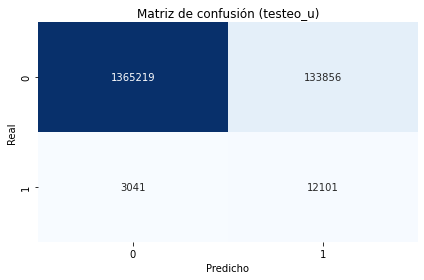

Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      0.91      0.95   1499075
           1       0.08      0.80      0.15     15142

    accuracy                           0.91   1514217
   macro avg       0.54      0.85      0.55   1514217
weighted avg       0.99      0.91      0.94   1514217



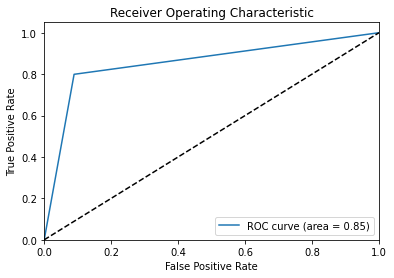

AUC: 0.8549377402244438


In [77]:
# Matriz de confusión
cm_test = confusion_matrix(y_test_u, X_test_pred_if_u)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Matriz de confusión (testeo_u)')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.tight_layout()
plt.show()
# Calcular el reporte de métricas
classification_test = classification_report(y_test_u, X_test_pred_if_u)
print('Classification Report (Test):\n', classification_test)
# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test_u, X_test_pred_if_u)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
print('AUC:', roc_auc)

Normal

In [78]:
while True:
    name = input("Ingrese el nombre de los archivos a cargar sin extensión para el modelo Isolation Forest entrenado con anomalías normal: ")
    
    try:
        model_if_n = load(f'{name}.joblib')
        print(f'Modelo {name} cargado desde la unidad local')
        break
        
    except FileNotFoundError:
        print(f'El archivo {name} no fue encontrado. Por favor, ingrese un nombre válido.')

Modelo if_n cargado desde la unidad local


In [79]:
X_test_pred_if_n = model_if_n.predict(data_test_X_n)

In [80]:
X_test_pred_if_n = np.where(X_test_pred_if_n == 1, 0, np.where(X_test_pred_if_n == -1, 1, X_test_pred_if_n))

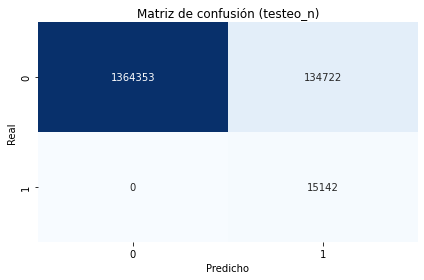

Classification Report (Test):
               precision    recall  f1-score   support

           0       1.00      0.91      0.95   1499075
           1       0.10      1.00      0.18     15142

    accuracy                           0.91   1514217
   macro avg       0.55      0.96      0.57   1514217
weighted avg       0.99      0.91      0.95   1514217



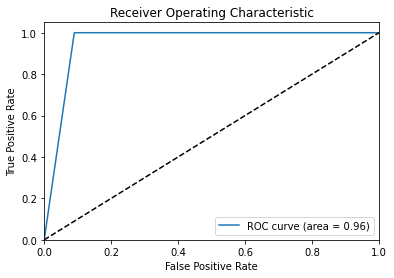

AUC: 0.9550649567233127


In [81]:
# Matriz de confusión
cm_test = confusion_matrix(y_test_n, X_test_pred_if_n)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Matriz de confusión (testeo_n)')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.tight_layout()
plt.show()
# Calcular el reporte de métricas
classification_test = classification_report(y_test_n, X_test_pred_if_n)
print('Classification Report (Test):\n', classification_test)
# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test_n, X_test_pred_if_n)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
print('AUC:', roc_auc)